In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "C3H"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = False

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
18955,Solyc03g043810.1.1,MNEKRNKSAEPNLSLSLKTPIEYESINNIPTLEEAVNLELKNGQVD...,125,0
16150,Sevir.2G357300.1.p,MAAEDTGDDASIALLHRLRSGATVHFVHHVDVCSAAPEDLVADLEP...,402,0
15099,GSBRNA2T00088813001,MSSTNGGYQENTNWIFQEVKDAMWTVEENKRFEKALAVLGDKDDLE...,234,0
3858,Itr_sc000399.1_g00004.1,MRDDLFIAAGEESVELGLQNHREKGVPKQVYVHPYSIIPPNPSVGL...,255,1
15228,GSBRNA2T00060740001,MGRKCSHCGSVGHNSRTCFSNKTRVIKLFGVHVDTTGSSPPPGPSS...,235,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 18955 to 600
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   object
 1   sequence  5000 non-null   object
 2   length    5000 non-null   int64 
 3   class     5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.3+ KB


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1392,0.007485,0.001497,0.007485,0.008982,0.001497,0.005988,0.000000,0.002994,0.005988,0.004491,...,0.000000,0.001497,0.000000,0.001497,0.000000,0.000000,0.000000,0.000000,0.0,0.001497
1323,0.020833,0.000000,0.000000,0.010417,0.005208,0.000000,0.000000,0.000000,0.000000,0.010417,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
432,0.010819,0.001546,0.004637,0.000000,0.003091,0.001546,0.003091,0.003091,0.001546,0.004637,...,0.000000,0.003091,0.000000,0.001546,0.004637,0.000000,0.000000,0.000000,0.0,0.000000
87,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,0.005464,0.000000,0.000000,...,0.005464,0.005464,0.000000,0.005464,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2581,0.001403,0.000000,0.005610,0.005610,0.004208,0.001403,0.002805,0.001403,0.002805,0.001403,...,0.000000,0.000000,0.001403,0.004208,0.000000,0.001403,0.001403,0.001403,0.0,0.001403


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.4688 - loss: 0.6934

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5853 - loss: 0.6897   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6280 - loss: 0.6773 - val_accuracy: 0.8500 - val_loss: 0.4391


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8281 - loss: 0.4578

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8142 - loss: 0.4058

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8231 - loss: 0.3879 - val_accuracy: 0.9225 - val_loss: 0.2162


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8438 - loss: 0.2791

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.2216

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9139 - loss: 0.2128 - val_accuracy: 0.9375 - val_loss: 0.1667


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.1841

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9322 - loss: 0.1599

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9337 - loss: 0.1585

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9340 - loss: 0.1583

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9341 - loss: 0.1582

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9344 - loss: 0.1581 - val_accuracy: 0.9212 - val_loss: 0.1978


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9531 - loss: 0.0942

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1293 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9465 - loss: 0.1371 - val_accuracy: 0.9237 - val_loss: 0.2005


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.3197

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9472 - loss: 0.1469

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9491 - loss: 0.1415 - val_accuracy: 0.9413 - val_loss: 0.1700


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0781

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9624 - loss: 0.0957

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1021 - val_accuracy: 0.9388 - val_loss: 0.1598


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0927

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9671 - loss: 0.0900

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.0929 - val_accuracy: 0.9087 - val_loss: 0.2487


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.1457

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9617 - loss: 0.1103

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9609 - loss: 0.1097 - val_accuracy: 0.9225 - val_loss: 0.1981


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9219 - loss: 0.1328

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9657 - loss: 0.0971

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9669 - loss: 0.0942 - val_accuracy: 0.9312 - val_loss: 0.1836


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0288

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0565

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.0615 - val_accuracy: 0.9350 - val_loss: 0.1749


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0490

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0623

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0641 - val_accuracy: 0.9400 - val_loss: 0.1622


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0328

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0543

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0550

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9796 - loss: 0.0551 - val_accuracy: 0.9362 - val_loss: 0.1658


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0530

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0449

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0451 - val_accuracy: 0.9450 - val_loss: 0.1703


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0354

 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9720 - loss: 0.0473

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9822 - loss: 0.0401 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0390 - val_accuracy: 0.9438 - val_loss: 0.1692


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0352

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0332

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0353 - val_accuracy: 0.9463 - val_loss: 0.1623


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0478

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0364

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0354 - val_accuracy: 0.9413 - val_loss: 0.1986


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0325

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0375 - val_accuracy: 0.9450 - val_loss: 0.1682


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0038

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0428

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0425 - val_accuracy: 0.9237 - val_loss: 0.2519


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.0711

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0215

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0203 - val_accuracy: 0.9388 - val_loss: 0.2144


Epoch 21/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0046

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0126

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0144 - val_accuracy: 0.9413 - val_loss: 0.1908


Epoch 22/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0076

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0167

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0152 - val_accuracy: 0.9388 - val_loss: 0.2095


Epoch 23/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0039

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0104

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0103 - val_accuracy: 0.9463 - val_loss: 0.1980


Epoch 24/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0044

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0083

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0094 - val_accuracy: 0.9463 - val_loss: 0.1960


Epoch 25/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0044

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0048

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0049 - val_accuracy: 0.9388 - val_loss: 0.2573


Epoch 26/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0059

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9450 - val_loss: 0.2196



[Train Accuracy: 99.47% - Test Accuracy: 93.60%]


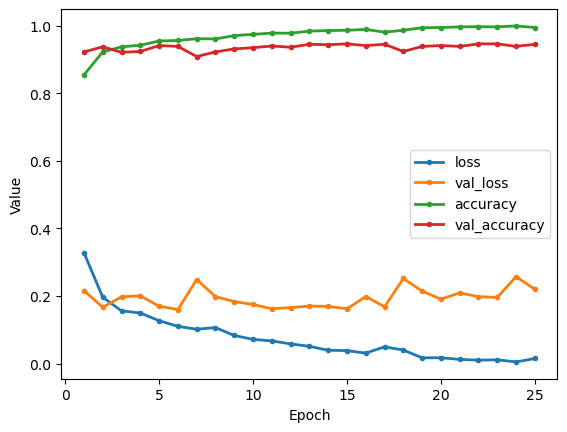

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2749,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1450,0.0,0.000000,0.0,0.002976,0.0,0.000000,0.0,0.0,0.0,0.002976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3255,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310,0.0,0.003257,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3036,0.0,0.000000,0.0,0.001605,0.0,0.001605,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8756)
X_test: (1000, 8756)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,241,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,285,057 (8.72 MB)

 Trainable params: 2,285,057 (8.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 23s 482ms/step - accuracy: 0.4688 - loss: 0.6931

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5202 - loss: 0.6929   

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5521 - loss: 0.6921

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5865 - loss: 0.6902

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6183 - loss: 0.6865

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6452 - loss: 0.6798

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6604 - loss: 0.6734 - val_accuracy: 0.9588 - val_loss: 0.3464


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.3338

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9482 - loss: 0.3028 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9492 - loss: 0.2648

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9525 - loss: 0.2360

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9552 - loss: 0.2150

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9575 - loss: 0.1992

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9586 - loss: 0.1917 - val_accuracy: 0.9800 - val_loss: 0.0619


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0163

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9885 - loss: 0.0291 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9896 - loss: 0.0290

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9901 - loss: 0.0280

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9905 - loss: 0.0271

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9908 - loss: 0.0263

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9909 - loss: 0.0260 - val_accuracy: 0.9625 - val_loss: 0.0970


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0447

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9951 - loss: 0.0187 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.0139

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0118

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0107

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0103

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0101 - val_accuracy: 0.9812 - val_loss: 0.0516


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0015

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0024

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9837 - val_loss: 0.0553


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.6607e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2376e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9378e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011    

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9862 - val_loss: 0.0512


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.4479e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3313e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9040e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0324e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8418e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6170e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4136e-04 - val_accuracy: 0.9850 - val_loss: 0.0526


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.3686e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7644e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4172e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2971e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1738e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2582e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3107e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3154e-04 - val_accuracy: 0.9837 - val_loss: 0.0646


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.6015e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7918e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7223e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7069e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7396e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7583e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7568e-04 - val_accuracy: 0.9850 - val_loss: 0.0572


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.7406e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4346e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1192e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0619e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0841e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0713e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0580e-04 - val_accuracy: 0.9850 - val_loss: 0.0597


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.1149e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2752e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4976e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5433e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5389e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5292e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5122e-04 - val_accuracy: 0.9850 - val_loss: 0.0600


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.9902e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5787e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3289e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0073e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0708e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1178e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1847e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1917e-04 - val_accuracy: 0.9850 - val_loss: 0.0620


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 7.4363e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2104e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1834e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4777e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6034e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6264e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6147e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6123e-04 - val_accuracy: 0.9837 - val_loss: 0.0673


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.8466e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9951e-05 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1879e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8873e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5296e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7433e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8055e-05 - val_accuracy: 0.9850 - val_loss: 0.0654


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.3317e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8529e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0697e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7541e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9536e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1444e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2448e-05 - val_accuracy: 0.9850 - val_loss: 0.0667


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.9216e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1857e-05 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2458e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1344e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0231e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9949e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9840e-05 - val_accuracy: 0.9850 - val_loss: 0.0669



[Train Accuracy: 100.00% - Test Accuracy: 98.50%]


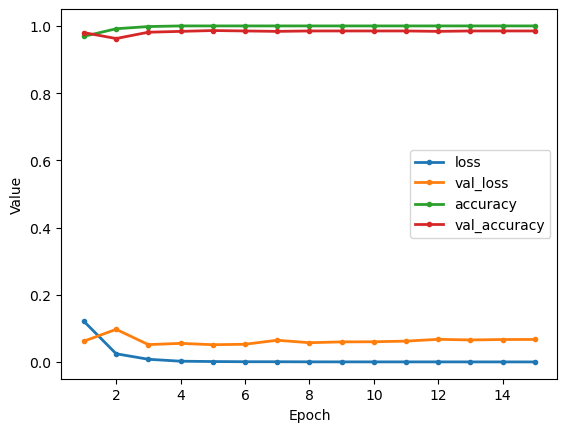

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYK,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV
2749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,264,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,305,601 (142.31 MB)

 Trainable params: 37,305,601 (142.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 39s 798ms/step - accuracy: 0.4375 - loss: 0.6932

 2/50 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.4375 - loss: 0.6933 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.4497 - loss: 0.6933

 4/50 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.4583 - loss: 0.6933

 5/50 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.4667 - loss: 0.6932

 6/50 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.4748 - loss: 0.6932

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.4807 - loss: 0.6932

 8/50 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.4848 - loss: 0.6932

 9/50 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.4884 - loss: 0.6931

10/50 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.4911 - loss: 0.6931

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.4941 - loss: 0.6931

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.4956 - loss: 0.6931

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.4968 - loss: 0.6931

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.4977 - loss: 0.6931

15/50 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.4985 - loss: 0.6930

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.4991 - loss: 0.6930

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.4997 - loss: 0.6930

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5002 - loss: 0.6929

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.5006 - loss: 0.6929

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.5012 - loss: 0.6929

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5023 - loss: 0.6928

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5039 - loss: 0.6928

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.5059 - loss: 0.6927

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.5083 - loss: 0.6927

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5110 - loss: 0.6926

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5138 - loss: 0.6925

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5168 - loss: 0.6924

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5198 - loss: 0.6923

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5230 - loss: 0.6922

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5263 - loss: 0.6921

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5296 - loss: 0.6920

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5331 - loss: 0.6919

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5365 - loss: 0.6917

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5400 - loss: 0.6916

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5434 - loss: 0.6914

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5469 - loss: 0.6912

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5504 - loss: 0.6910

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5539 - loss: 0.6908

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5574 - loss: 0.6905

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5608 - loss: 0.6903

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5642 - loss: 0.6900

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5675 - loss: 0.6897

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5708 - loss: 0.6894

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5741 - loss: 0.6890

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5773 - loss: 0.6887

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5805 - loss: 0.6883

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5837 - loss: 0.6878

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5868 - loss: 0.6874

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5899 - loss: 0.6869

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5929 - loss: 0.6864

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.5959 - loss: 0.6859 - val_accuracy: 0.9350 - val_loss: 0.5249


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 14s 305ms/step - accuracy: 0.9531 - loss: 0.4973

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9648 - loss: 0.4898 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9627 - loss: 0.4872

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9613 - loss: 0.4838

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9609 - loss: 0.4799

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9605 - loss: 0.4765

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9600 - loss: 0.4729

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9597 - loss: 0.4693

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9595 - loss: 0.4655

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9595 - loss: 0.4617

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9596 - loss: 0.4579

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9598 - loss: 0.4541

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9602 - loss: 0.4502

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9606 - loss: 0.4463

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9609 - loss: 0.4423

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9612 - loss: 0.4382

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9613 - loss: 0.4343

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9615 - loss: 0.4303

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9615 - loss: 0.4264

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9617 - loss: 0.4225

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9618 - loss: 0.4187

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9620 - loss: 0.4148

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9622 - loss: 0.4110

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9623 - loss: 0.4072

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9624 - loss: 0.4036

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9625 - loss: 0.4000

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9626 - loss: 0.3964

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9627 - loss: 0.3929

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9628 - loss: 0.3894

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9629 - loss: 0.3860

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9631 - loss: 0.3825

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9633 - loss: 0.3792

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9634 - loss: 0.3758

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9636 - loss: 0.3726

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9638 - loss: 0.3693

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9640 - loss: 0.3661

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9642 - loss: 0.3630

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9644 - loss: 0.3599

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9645 - loss: 0.3569

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9647 - loss: 0.3540

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9649 - loss: 0.3511

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9650 - loss: 0.3482

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9652 - loss: 0.3454

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9653 - loss: 0.3426

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9655 - loss: 0.3398

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9656 - loss: 0.3371

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9658 - loss: 0.3345

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9659 - loss: 0.3318

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9661 - loss: 0.3293

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9662 - loss: 0.3267

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9664 - loss: 0.3243 - val_accuracy: 0.9800 - val_loss: 0.0711


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.9844 - loss: 0.0300

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9883 - loss: 0.0281

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9905 - loss: 0.0257

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9919 - loss: 0.0243

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9929 - loss: 0.0234

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9936 - loss: 0.0227

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9942 - loss: 0.0220

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9944 - loss: 0.0217

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9947 - loss: 0.0215

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9947 - loss: 0.0213

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9948 - loss: 0.0212

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9949 - loss: 0.0210

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9950 - loss: 0.0207

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9952 - loss: 0.0205

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9953 - loss: 0.0202

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9954 - loss: 0.0200

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9955 - loss: 0.0197

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9956 - loss: 0.0194

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9957 - loss: 0.0192

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9958 - loss: 0.0190

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9959 - loss: 0.0188

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9960 - loss: 0.0186

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9961 - loss: 0.0184

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9962 - loss: 0.0182

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9962 - loss: 0.0180

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9963 - loss: 0.0178

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9964 - loss: 0.0176

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9965 - loss: 0.0175

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9965 - loss: 0.0173

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9966 - loss: 0.0171

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9966 - loss: 0.0170

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9967 - loss: 0.0168

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9968 - loss: 0.0167

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9968 - loss: 0.0165

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9969 - loss: 0.0164

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9969 - loss: 0.0163

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9970 - loss: 0.0161

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9970 - loss: 0.0160

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9971 - loss: 0.0159

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9971 - loss: 0.0158

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9971 - loss: 0.0156

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9972 - loss: 0.0155

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9972 - loss: 0.0154

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9973 - loss: 0.0153

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9973 - loss: 0.0152

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9973 - loss: 0.0151

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9974 - loss: 0.0150

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9974 - loss: 0.0149

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9974 - loss: 0.0148

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9975 - loss: 0.0147

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.9975 - loss: 0.0146 - val_accuracy: 0.9850 - val_loss: 0.0431


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 1.0000 - loss: 0.0028

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0025

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 0.0024

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 0.0024

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0024

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 0.0024

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0023

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0023

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0023

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0023

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 0.0023

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0023

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0023

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0023

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0023

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 0.0022

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 0.0022

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0022

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0022

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 0.0022

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0022

22/50 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 0.0022

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 0.0022

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0021

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 0.0021

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 0.0021

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 0.0021

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 0.0021

29/50 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 0.0021

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 0.0021

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 0.0021

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 0.0021

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 0.0021

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 0.0021

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 0.0021

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0021

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0021

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0021

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0021

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0021

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.0021

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.0021

43/50 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 0.0021

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0021

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0021

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0021

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0021

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 0.0021

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0021

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0021

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9862 - val_loss: 0.0391


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 1.0000 - loss: 0.0013

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 0.0013

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0012

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0012

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 0.0012

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0012

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0012

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0012

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0012

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 0.0012

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 0.0012

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 0.0012

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0012

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0012

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0012

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0012

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0012

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0012

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0012

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0012

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0012

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0012

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 0.0012

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 0.0012

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 0.0012

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0012

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0012

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0012

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0012

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0012

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0012

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0012

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0012

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0012

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0012

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0012

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0012

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0012

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9875 - val_loss: 0.0330


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 1.0000 - loss: 5.1726e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 5.4821e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 5.3531e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 5.2546e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 5.2478e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 5.2166e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 5.4875e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 5.6353e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 5.7041e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.7934e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.8400e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.8692e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.8822e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.8797e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 5.8832e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 5.8874e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.8970e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.9061e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.9169e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.9248e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.9393e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.9471e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.9473e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.9408e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.9333e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.9279e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.9207e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.9149e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.9068e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.9154e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 5.9223e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 5.9285e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 5.9377e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9429e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9456e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9459e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9440e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9431e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9436e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9430e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9408e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.9414e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.9402e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.9383e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.9357e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.9317e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.9272e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.9221e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.9171e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.9114e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 5.9060e-04 - val_accuracy: 0.9862 - val_loss: 0.0331


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 1.0000 - loss: 2.1784e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.5942e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.5681e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 2.5205e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 2.4531e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 2.4268e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.5345e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.6518e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.7624e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.8411e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.8979e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.9639e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.0203e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.0585e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.0846e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.1009e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.1106e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.1165e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.1448e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.1655e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.1817e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.1921e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.1997e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.2054e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.2099e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.2134e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.2151e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.2171e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.2175e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.2164e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.2140e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.2238e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.2320e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.2380e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2429e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2463e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2491e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2514e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2522e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2535e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2543e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2542e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2610e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2694e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2766e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2860e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2943e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.3015e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.3078e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.3134e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 1.0000 - loss: 3.3189e-04 - val_accuracy: 0.9887 - val_loss: 0.0301


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 1.0000 - loss: 1.1081e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.7602e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 1.0000 - loss: 3.0332e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 1.0000 - loss: 3.0806e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 1.0000 - loss: 3.0431e-04 

 6/50 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 1.0000 - loss: 3.0012e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 1.0000 - loss: 2.9561e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 1.0000 - loss: 2.9199e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 1.0000 - loss: 2.8841e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 1.0000 - loss: 2.8410e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 1.0000 - loss: 2.7977e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 1.0000 - loss: 2.7518e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 1.0000 - loss: 2.7053e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 1.0000 - loss: 2.6663e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 1.0000 - loss: 2.6312e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 1.0000 - loss: 2.5957e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 2.5705e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 2.5466e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 2.5236e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 2.5012e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 1.0000 - loss: 2.4793e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 1.0000 - loss: 2.4582e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 1.0000 - loss: 2.4451e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 1.0000 - loss: 2.4322e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 1.0000 - loss: 2.4196e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 1.0000 - loss: 2.4065e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 1.0000 - loss: 2.3931e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 1.0000 - loss: 2.3830e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 1.0000 - loss: 2.3731e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 1.0000 - loss: 2.3645e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 2.3561e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 2.3498e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 1.0000 - loss: 2.3432e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 2.3363e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 1.0000 - loss: 2.3306e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 1.0000 - loss: 2.3241e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 2.3174e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 2.3105e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 2.3052e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 1.0000 - loss: 2.2995e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 2.2936e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 2.2875e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 1.0000 - loss: 2.2819e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 1.0000 - loss: 2.2762e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 2.2706e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 2.2649e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 1.0000 - loss: 2.2593e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 1.0000 - loss: 2.2536e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 2.2480e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 2.2422e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 1.0000 - loss: 2.2366e-04 - val_accuracy: 0.9862 - val_loss: 0.0327


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 1.0000 - loss: 1.4789e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4864e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.5690e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.5556e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.5535e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5300e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.5059e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4815e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4541e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4336e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4121e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.3948e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.3795e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3982e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4147e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4510e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.4872e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.5213e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.5547e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.5822e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.6039e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.6212e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.6364e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.6479e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.6570e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.6648e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.6709e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.6755e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.6794e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.6833e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.6864e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.6882e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.6887e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.6884e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.6872e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.6859e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.6840e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.6818e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.6795e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.6770e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6740e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6710e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.6684e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.6655e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.6628e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.6599e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.6569e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.6540e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.6514e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.6486e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.6459e-04 - val_accuracy: 0.9862 - val_loss: 0.0314


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 1.0000 - loss: 7.0178e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 8.2149e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 9.2411e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 9.5308e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.6995e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 9.9852e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.0235e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.0675e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0953e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.1085e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.1191e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.1250e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.1287e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.1411e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.1509e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1587e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1641e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.1690e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.1717e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1742e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1786e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1819e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1880e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1933e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1976e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2012e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.2054e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.2091e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.2116e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.2143e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.2167e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.2186e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.2200e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2208e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.2212e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.2212e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.2210e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.2206e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2207e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2229e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2249e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.2265e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.2281e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.2296e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.2305e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 1.2309e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 1.2314e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 1.2316e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 1.2315e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 1.2315e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 1.0000 - loss: 1.2314e-04 - val_accuracy: 0.9875 - val_loss: 0.0305


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 450ms/step - accuracy: 1.0000 - loss: 3.4793e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 3.0434e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.7591e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.5591e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.3953e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.2766e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.1795e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 2.1079e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.0402e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 1.0000 - loss: 1.9764e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 1.0000 - loss: 1.9167e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 1.8625e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.8175e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.7758e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.7390e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.7045e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.6708e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.6404e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.6110e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.5833e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.5597e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.5379e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 1.5171e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 1.4975e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.4801e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 1.4633e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.4476e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.4329e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.4195e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.4062e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3937e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3816e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3696e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3578e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.3461e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.3349e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3246e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3151e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3056e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.2961e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.2879e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.2800e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.2724e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.2657e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.2603e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 1.2550e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 1.2499e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 1.2448e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 1.2402e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 1.2355e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 1.0000 - loss: 1.2310e-04 - val_accuracy: 0.9862 - val_loss: 0.0319


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 1.0000 - loss: 4.9856e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 4.1850e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 4.7031e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 5.0925e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.4024e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.5599e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 5.8423e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 6.0213e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 6.1426e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 6.2139e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 6.2691e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 6.3578e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.4293e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 6.5053e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 6.5695e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.6266e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.7244e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.7923e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.8432e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.8757e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.8984e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.9240e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.9451e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.9629e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.9755e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.9898e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.0002e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.0037e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.0025e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.0119e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.2655e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.6392e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.9828e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.3274e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.6426e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.9315e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.1952e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.4404e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.6761e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 9.8925e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.0105e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.0306e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0494e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0690e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0873e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.1051e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1225e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1392e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1547e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1692e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.1830e-04 - val_accuracy: 0.9887 - val_loss: 0.0271


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 1.0000 - loss: 4.9502e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.4279e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.7754e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.1378e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3724e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2199e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 8.2627e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.9412e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 9.3464e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.0911e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2046e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.2874e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3467e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3978e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4351e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.4621e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4813e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4943e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.5041e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.5102e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.5130e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.5132e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.5110e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.5075e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.5031e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.4988e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.4935e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.4880e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4844e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4873e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4888e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4890e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4884e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4872e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4850e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4824e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4791e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4752e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4708e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4659e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4607e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4552e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4496e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4441e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4389e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4336e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4284e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4237e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4191e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4143e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.4097e-04 - val_accuracy: 0.9862 - val_loss: 0.0331


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 1.0000 - loss: 4.8131e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 4.6839e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 4.5724e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.5413e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 4.7181e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 4.9683e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.1142e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.1864e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 5.2137e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 5.2659e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.3267e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.3671e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.4160e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.4383e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.4470e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.4481e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 5.4496e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.4512e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.4480e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.4375e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.4301e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 5.4227e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.4130e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.4022e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.3877e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 5.3730e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 5.3590e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 5.3464e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 5.3356e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 5.3385e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.3376e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 5.3333e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 5.3265e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 5.3196e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.3107e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.3022e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.2939e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.2845e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.2743e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.2630e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 5.2509e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 5.2407e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 5.2317e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 5.2232e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.2139e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.2039e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 5.1931e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 5.1830e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.1728e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.1621e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.1518e-05 - val_accuracy: 0.9875 - val_loss: 0.0315


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 17s 365ms/step - accuracy: 1.0000 - loss: 3.2469e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.8877e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.8325e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.7706e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.7658e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7917e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.8058e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7980e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.8055e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.8255e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.8723e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.9248e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.9666e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.9974e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 3.0167e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.0504e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 3.0777e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.1093e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.1374e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.1632e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.1861e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.2065e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.2237e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.2404e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.2546e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.2731e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.2965e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.3174e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.3368e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.3537e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.3679e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.3813e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.3973e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4140e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4292e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4424e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4535e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4650e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4767e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.4866e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.4961e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.5047e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.5200e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.5335e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5466e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5586e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5690e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5795e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5919e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.6031e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.6140e-05 - val_accuracy: 0.9862 - val_loss: 0.0339


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 1.0000 - loss: 2.0333e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 2.0775e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.9694e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.9402e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.8920e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.8605e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.8265e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.9553e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.2220e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.4069e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.6122e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.7715e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.9123e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 3.0260e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 3.1121e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 3.1792e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 3.2323e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.2721e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3071e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3330e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3513e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3640e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3718e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3855e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3967e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4040e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4111e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4145e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4151e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4179e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4182e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4176e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4152e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4121e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4092e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4064e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4040e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4026e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.4015e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.3988e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.3957e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.3953e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.3954e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3946e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3952e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3958e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3959e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3954e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3941e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3923e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3906e-05 - val_accuracy: 0.9862 - val_loss: 0.0341


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 1.0000 - loss: 3.5511e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 2.9893e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 2.9314e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.8373e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 2.9073e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.9603e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.9600e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.9802e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.0173e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 3.0545e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.0772e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.0956e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 3.1118e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 3.1202e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 3.1426e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 3.1556e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.1797e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 3.1989e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.2245e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.2486e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.2677e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3005e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.3264e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.3458e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.3650e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.3808e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.3958e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4067e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.4150e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4206e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4274e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4321e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.4344e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4350e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4334e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4310e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.4284e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.4263e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.4265e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.4254e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.4258e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.4252e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.4246e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.4234e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.4260e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.4276e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4289e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4315e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4338e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4357e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 3.4376e-05 - val_accuracy: 0.9875 - val_loss: 0.0294



[Train Accuracy: 100.00% - Test Accuracy: 99.20%]


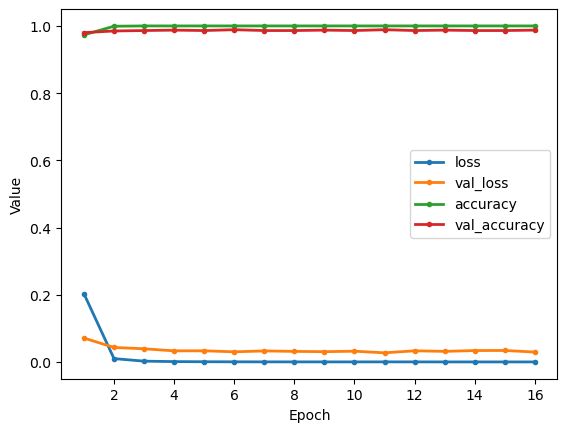

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/C3H/report_BP1P4D0E.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [28]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [30]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [31]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [32]:
# END

In [33]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################